In [1]:
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
from specim.specfuncs import spec1d
import numpy as np
import matplotlib.pyplot as plt
import glob
from random import sample
import pandas as pd
import seaborn as sn
import pm_veldis_util as vd
from collections import Counter

In [2]:
data = spec1d.Spec1d('../0712_lris_feb97_lens.spec') 


Reading spectrum from ../0712_lris_feb97_lens.spec
Expected file format: text
 Spectrum Start:  3595.42
 Spectrum End:     8588.21
 Dispersion (1st pixel):   2.44
 Dispersion (average):      2.44




Line        lambda_rest  lambda_obs
----------  -----------  -----------
Fe II         2587.00       3634.74
Fe II         2600.00       3653.00
Fe II         2750.30       3864.17
Mg II         2795.53       3927.72
Mg II         2802.71       3937.81
Mg I          2852.00       4007.06
H-kappa       3750.00       5268.75
[Fe VII]      3761.40       5284.77
H-iota        3770.00       5296.85
H-theta       3797.00       5334.78
H-eta         3835.00       5388.18
CN bandhd     3883.00       5455.61
CaII K        3933.67       5526.81
CaII H        3968.47       5575.70
H-delta       4101.00       5761.90
G-band        4305.00       6048.53
H-gamma       4340.00       6097.70
Fe4383        4383.00       6158.11
Ca4455        4455.00       6259.28
Fe4531        4531.00       6366.06
H-beta        4861.00       6829.70
Mg I (b)      5176.00       7272.28
Na I (D)      5889.95       8275.38
Na I (D)      5895.92       8283.77



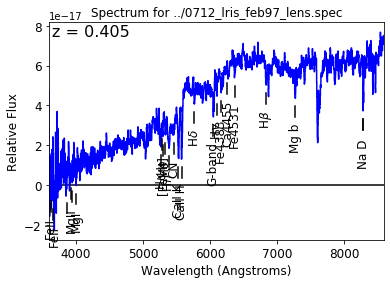

In [3]:
#%matplotlib notebook
data.plot()
data.mark_lines('abs', z=0.405)

In [4]:
z = 0.405
lam_temp_ini = 3465.0       
lam_temp_fin = 9469.00
lam_range_min = lam_temp_ini*(1+z)
lam_range_max = lam_temp_fin*(1+z)
print(lam_range_min)
print(lam_range_max)

4868.325
13303.945


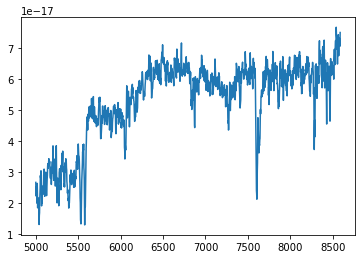

In [5]:
lamda_galaxy = data['wav'][575:]
spectra_galaxy = data['flux'][575:]
#variance_spectra_galaxy = data['var']
lamda_galaxy_range =  [np.min(lamda_galaxy), np.max(lamda_galaxy)]
#lamda_galaxy.tolist().index(4999.94676193628)
plt.plot(lamda_galaxy, spectra_galaxy)

Velocity scale = 146.423658 km/s
dv = -109938.280949 


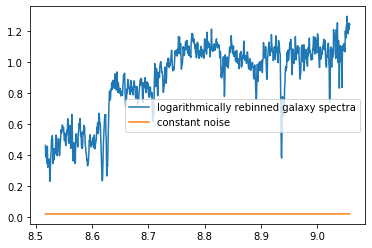

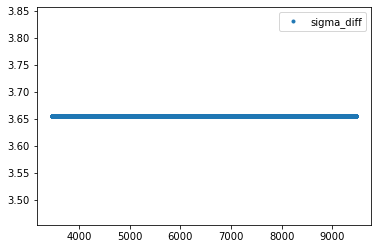

In [6]:
# Calulating velocity scale

velocity_scale = vd.velocity_scale(lamda_galaxy)

# Calculating the parameter 'dv'

dv = vd.wav_dev(lamda_galaxy[0])

# Initial guess for velocity and velocity dispersion

c = 299792.458
vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017)
start = [vel, 200.0]  

# Logarithmically rebinning the galaxy spectra

median_spectra_gal = np.median(spectra_galaxy)       # median of the spectra_galaxy
spectra_galaxy_normalized = spectra_galaxy / median_spectra_gal
spectra_galaxy_rebinned, log_lamda_galaxy, v = util.log_rebin(lamda_galaxy_range, spectra_galaxy_normalized, 
                                                         velscale=velocity_scale)
#plt.plot(log_lamda_galaxy, spectra_galaxy_rebinned)
#plt.title('logarithmically rebinned galaxy spectra')
#plt.show()

## Noise

#sigma_galaxy_spectra = np.sqrt(variance_spectra_galaxy) 
#noise = sigma_galaxy_spectra / median_spectra_gal

constant_noise = np.full_like(spectra_galaxy_rebinned, 0.02) 
#noise_rebinned, log_lamda_noise, velo_scale = util.log_rebin(lamda_galaxy_range, noise,
#                                                          velscale=velocity_scale)

#plt.plot(log_lamda_noise, noise_rebinned)
#plt.title('logarithmically rebinned noise')
plt.plot(log_lamda_galaxy, spectra_galaxy_rebinned, label='logarithmically rebinned galaxy spectra')
plt.plot(log_lamda_galaxy, constant_noise, label='constant noise')
plt.legend()
plt.show()
#print(velo_scale)
#print(np.size(noise_new))


# Calculating the difference in sigma between the instrumental LSF of the galaxy spectra and templates.
# Here sigma of the instrument, 'sig_ins', has been obtained by performing Gaussian fit with several emission 
# lines from the galaxy spectra.

sigma_diff = vd.gen_sigma_diff(sig_ins=3.70, lam_gal=lamda_galaxy)



In [7]:
mask_region = [[(8.8283, 8.8401), (8.9313, 8.9484)], [(8.8283, 8.8401), (8.9313, 8.9484), (9.0315, 9.0577)]]
#                (8.8329, 8.8371)

In [8]:
templates = vd.gen_rebinned_templates(lib_path='../TEXT/*', temp_num=850, sigma_diff=sigma_diff,
                                      v=velocity_scale)

In [ ]:
for i, m in enumerate(mask_region):
    mask = vd.masking(m, log_lamda_galaxy)
    pp = ppxf(templates, spectra_galaxy_rebinned, constant_noise, velocity_scale, start, moments=4,
            plot=True, vsyst=dv, degree=6, mask=mask, lam=np.exp(log_lamda_galaxy))
    plt.figure()

In [ ]:
degree = np.arange(4,12)
velocity_dispersion = np.zeros(len(degree))
error = np.zeros(len(degree))
mask = vd.masking(mask_region[1], log_lamda_galaxy)
for i in range(len(degree)):
    pp = ppxf(templates, spectra_galaxy_rebinned, constant_noise, velocity_scale, start, moments=4,
         plot=True, degree=degree[i], vsyst=dv, mask= mask, lam=np.exp(log_lamda_galaxy))
    velocity_dispersion[i] = pp.sol[1]
    error[i] = pp.error[1]*sqrt(pp.chi2)
    plt.figure()
    print('degree : %d' %degree[i])

In [ ]:
plt.plot(degree, velocity_dispersion, '.')
plt.xlabel('degree')
plt.ylabel('velocity dispersion')
plt.ylim(210, 220)
plt.figure()

In [ ]:
lamda_galaxy = data['wav'][575:1190]
spectra_galaxy = data['flux'][575:1190]
#variance_spectra_galaxy = data['var'][575:1190]
lamda_galaxy_range =  [lamda_galaxy[0], lamda_galaxy[-1]]
plt.plot(lamda_galaxy, spectra_galaxy)

In [ ]:
# Calulating velocity scale

velocity_scale = vd.velocity_scale(lamda_galaxy)

# Calculating the parameter 'dv'

dv = vd.wav_dev(lamda_galaxy[0])

# Initial guess for velocity and velocity dispersion

c = 299792.458
vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017)
start = [vel, 200.0]  

# Logarithmically rebinning the galaxy spectra

median_spectra_gal = np.median(spectra_galaxy)       # median of the spectra_galaxy
spectra_galaxy_normalized = spectra_galaxy / median_spectra_gal
spectra_galaxy_rebinned, log_lamda_galaxy, v = util.log_rebin(lamda_galaxy_range, spectra_galaxy_normalized, 
                                                         velscale=velocity_scale)
#plt.plot(log_lamda_galaxy, spectra_galaxy_rebinned)
#plt.title('logarithmically rebinned galaxy spectra')
#plt.show()

## Noise

#sigma_galaxy_spectra = np.sqrt(variance_spectra_galaxy) 
#noise = sigma_galaxy_spectra / median_spectra_gal

constant_noise = np.full_like(spectra_galaxy_rebinned, 0.02) 
#noise_rebinned, log_lamda_noise, velo_scale = util.log_rebin(lamda_galaxy_range, noise,
#                                                          velscale=velocity_scale)

#plt.plot(log_lamda_noise, noise_rebinned)
#plt.title('logarithmically rebinned noise')
plt.plot(log_lamda_galaxy, spectra_galaxy_rebinned, label='logarithmically rebinned galaxy spectra')
plt.plot(log_lamda_galaxy, constant_noise, label='constant noise')
plt.legend()
plt.show()
#print(velo_scale)
#print(np.size(noise_new))


# Calculating the difference in sigma between the instrumental LSF of the galaxy spectra and templates.
# Here sigma of the instrument, 'sig_ins', has been obtained by performing Gaussian fit with several emission 
# lines from the galaxy spectra.

sigma_diff = vd.gen_sigma_diff(sig_ins=3.70, lam_gal=lamda_galaxy)



In [ ]:
templates = vd.gen_rebinned_templates(lib_path='../TEXT/*', temp_num=650, sigma_diff=sigma_diff,
                                      v=velocity_scale)

In [ ]:
degree = np.arange(4,10)
velocity_dispersion = np.zeros(len(degree))
error = np.zeros(len(degree))
#mask = vd.masking(mask_region[1], log_lamda_galaxy)
for i in range(len(degree)):
    pp = ppxf(templates, spectra_galaxy_rebinned, constant_noise, velocity_scale, start, moments=4,
         plot=True, degree=degree[i], vsyst=dv, lam=np.exp(log_lamda_galaxy))
    velocity_dispersion[i] = pp.sol[1]
    #error[i] = pp.error*np.sqrt(pp.chi2)
    plt.figure()
    print('degree : %d' %degree[i])

In [ ]:
print(error)

In [ ]:
lamda_galaxy = data['wav'][1190:]
spectra_galaxy = data['flux'][1190:]
#variance_spectra_galaxy = data['var'][575:1190]
lamda_galaxy_range =  [lamda_galaxy[0], lamda_galaxy[-1]]
plt.plot(lamda_galaxy, spectra_galaxy)

In [ ]:
# Calulating velocity scale

velocity_scale = vd.velocity_scale(lamda_galaxy)

# Calculating the parameter 'dv'

dv = vd.wav_dev(lamda_galaxy[0])

# Initial guess for velocity and velocity dispersion

c = 299792.458
vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017)
start = [vel, 200.0]  

# Logarithmically rebinning the galaxy spectra

median_spectra_gal = np.median(spectra_galaxy)       # median of the spectra_galaxy
spectra_galaxy_normalized = spectra_galaxy / median_spectra_gal
spectra_galaxy_rebinned, log_lamda_galaxy, v = util.log_rebin(lamda_galaxy_range, spectra_galaxy_normalized, 
                                                         velscale=velocity_scale)
#plt.plot(log_lamda_galaxy, spectra_galaxy_rebinned)
#plt.title('logarithmically rebinned galaxy spectra')
#plt.show()

## Noise

#sigma_galaxy_spectra = np.sqrt(variance_spectra_galaxy) 
#noise = sigma_galaxy_spectra / median_spectra_gal

constant_noise = np.full_like(spectra_galaxy_rebinned, 0.02) 
#noise_rebinned, log_lamda_noise, velo_scale = util.log_rebin(lamda_galaxy_range, noise,
#                                                          velscale=velocity_scale)

#plt.plot(log_lamda_noise, noise_rebinned)
#plt.title('logarithmically rebinned noise')
plt.plot(log_lamda_galaxy, spectra_galaxy_rebinned, label='logarithmically rebinned galaxy spectra')
plt.plot(log_lamda_galaxy, constant_noise, label='constant noise')
plt.legend()
plt.show()
#print(velo_scale)
#print(np.size(noise_new))


# Calculating the difference in sigma between the instrumental LSF of the galaxy spectra and templates.
# Here sigma of the instrument, 'sig_ins', has been obtained by performing Gaussian fit with several emission 
# lines from the galaxy spectra.

sigma_diff = vd.gen_sigma_diff(sig_ins=3.70, lam_gal=lamda_galaxy)



In [ ]:
mask_region = [[(8.8283, 8.8401), (8.9313, 8.9484)], [(8.8283, 8.8401), (8.9313, 8.9484), (9.0315, 9.0577)]]
#                (8.8329, 8.8371)

In [ ]:
for i, m in enumerate(mask_region):
    mask = vd.masking(m, log_lamda_galaxy)
    pp = ppxf(templates, spectra_galaxy_rebinned, constant_noise, velocity_scale, start, moments=4,
            plot=True, vsyst=dv, degree=6, mask=mask, lam=np.exp(log_lamda_galaxy))
    plt.figure()

In [ ]:
degree = np.arange(4,12)
velocity_dispersion = np.zeros(len(degree))
error = np.zeros(len(degree))
mask = vd.masking(mask_region[1], log_lamda_galaxy)
for i in range(len(degree)):
    pp = ppxf(templates, spectra_galaxy_rebinned, constant_noise, velocity_scale, start, moments=4,
         plot=True, degree=degree[i], vsyst=dv, mask= mask, lam=np.exp(log_lamda_galaxy))
    velocity_dispersion[i] = pp.sol[1]
    #error[i] = pp.error*sqrt(pp.chi2)
    plt.figure()
    print('degree : %d' %degree[i])

In [ ]:
plt.plot(degree, velocity_dispersion, '.')
plt.xlabel('degree')
plt.ylabel('velocity dispersion')
plt.ylim(220, 230)
plt.figure()